## ECON470 Homework 3-1
Author: Sarina Tan

In [32]:
# Importing the libraries 
# Import libraries
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from scipy.spatial.distance import mahalanobis
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
from tabulate import tabulate
from statsmodels.formula.api import ols
from linearmodels.iv import IV2SLS
from causalinference import CausalModel
from sklearn.neighbors import NearestNeighbors
from IPython.display import Markdown, display
import warnings
warnings.simplefilter('ignore')

1. Present a bar graph showing the proportion of states with a change in their cigarette tax in each year from 1970 to 1985.

In [15]:
# Load data
df = pd.read_csv("/Users/sarinatan/Desktop/HLTH470hw3/data/output/TaxBurden_Data.csv")
# Focus only on years 1970-1985
df = df[(df['Year'] >= 1970) & (df['Year'] <= 1985)]
# Sort data
df = df.sort_values(by=['state', 'Year'])

In [16]:
df['tax_change'] = df.groupby('state')['tax_state'].diff().notnull() & (df.groupby('state')['tax_state'].diff() != 0)

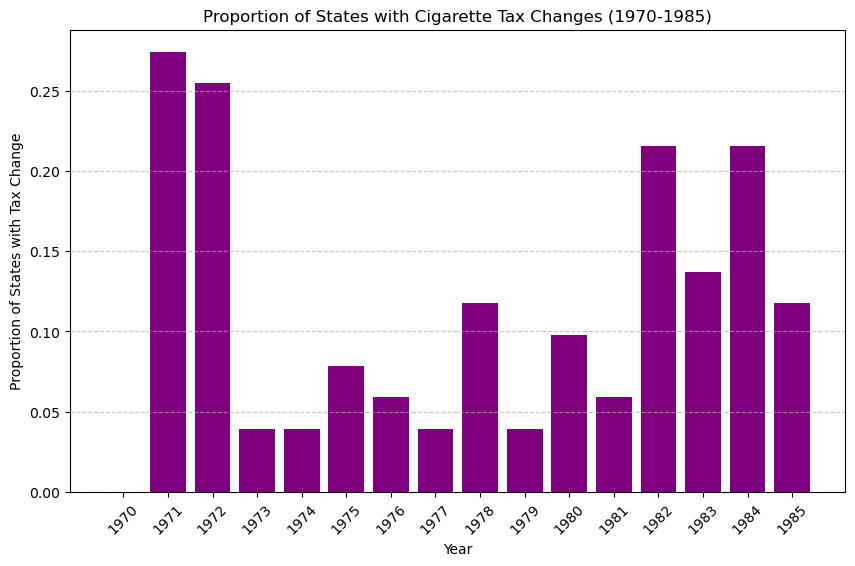

In [17]:
# Total number of states per year
states_per_year = df.groupby('Year')['state'].nunique()

# Number of states with a tax change each year
states_with_change_per_year = df[df['tax_change']].groupby('Year')['state'].nunique()

# Proportion of states with a tax change
proportion_with_change = (states_with_change_per_year / states_per_year).fillna(0).reset_index()
proportion_with_change.columns = ['Year', 'Proportion']

# Prepare graph
plt.figure(figsize=(10,6))
plt.bar(proportion_with_change['Year'], proportion_with_change['Proportion'], color='purple')
plt.title('Proportion of States with Cigarette Tax Changes (1970-1985)')
plt.xlabel('Year')
plt.ylabel('Proportion of States with Tax Change')
plt.xticks(proportion_with_change['Year'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

2. Plot on a single graph the average tax (in 2012 dollars) on cigarettes and the average price of a pack of cigarettes from 1970 to 2018.

In [18]:
# Filter for years 1970 to 2018
df = df[(df['Year'] >= 1970) & (df['Year'] <= 2018)]

# Use CPI to adjust to 2012 dollars
# Assuming 2012 CPI = 230 (You should check the exact CPI value for 2012 from your dataset if available)
df['cost_per_pack_2012'] = df['cost_per_pack'] * (230 / df['index'])
df['tax_state_2012'] = df['tax_state'] * (230 / df['index'])

# Group by year and compute average across all states
annual_avg = df.groupby('Year').agg({
    'cost_per_pack_2012': 'mean',
    'tax_state_2012': 'mean'
}).reset_index()

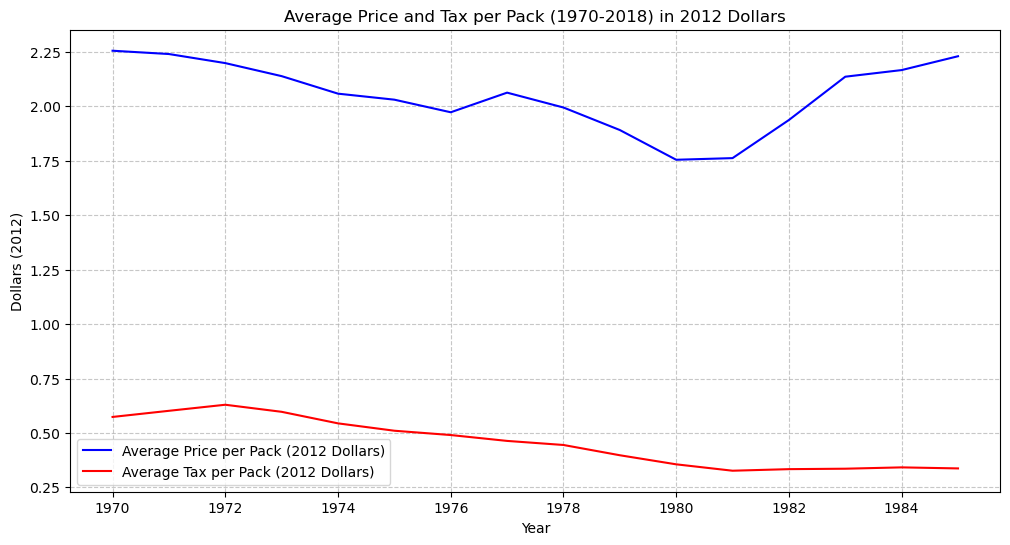

In [19]:
# Plot
plt.figure(figsize=(12, 6))

plt.plot(annual_avg['Year'], annual_avg['cost_per_pack_2012'], label='Average Price per Pack (2012 Dollars)', color='blue')
plt.plot(annual_avg['Year'], annual_avg['tax_state_2012'], label='Average Tax per Pack (2012 Dollars)', color='red')

plt.title('Average Price and Tax per Pack (1970-2018) in 2012 Dollars')
plt.xlabel('Year')
plt.ylabel('Dollars (2012)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

3. Identify the 5 states with the highest increases in cigarette prices (in dollars) over the time period. Plot the average number of packs sold per capita for those states from 1970 to 2018.

In [20]:
# Identify price change over time per state
price_change = df.groupby('state')['cost_per_pack'].agg(['first', 'last']).reset_index()
price_change['price_increase'] = price_change['last'] - price_change['first']

# Get top 5 states with highest price increases
top5_states = price_change.sort_values('price_increase', ascending=False).head(5)['state']

print("Top 5 states with highest cigarette price increases in cigarette prices in dollars:")
print(top5_states)

# Filter dataset to only those states
top5_df = df[df['state'].isin(top5_states)]

# Group by year and state to calculate average packs sold per capita
packs_per_capita = top5_df.groupby(['Year', 'state'])['sales_per_capita'].mean().reset_index()

Top 5 states with highest cigarette price increases in cigarette prices in dollars:
47              Washington
11                  Hawaii
8     District of Columbia
23               Minnesota
37                  Oregon
Name: state, dtype: object


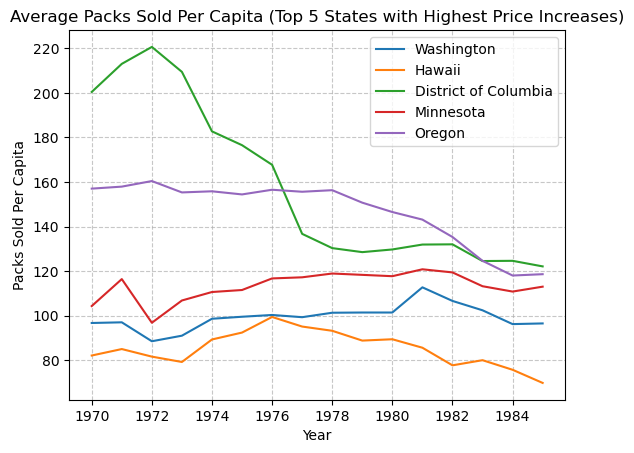

In [21]:
for state in top5_states:
    state_data = packs_per_capita[packs_per_capita['state'] == state]
    plt.plot(state_data['Year'], state_data['sales_per_capita'], label=state)

plt.title('Average Packs Sold Per Capita (Top 5 States with Highest Price Increases)')
plt.xlabel('Year')
plt.ylabel('Packs Sold Per Capita')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [22]:
price_change = df.groupby('state')['cost_per_pack'].agg(['first', 'last']).reset_index()

# Calculate the total increase in price
price_change['price_increase'] = price_change['last'] - price_change['first']

bottom5_states = price_change.sort_values('price_increase', ascending=True).head(5)['state']

print("5 states with the lowest cigarette price increases:")
print(bottom5_states.tolist())

bottom5_df = df[df['state'].isin(bottom5_states)]

# Group by year and state to calculate average packs sold per capita
packs_per_capita = bottom5_df.groupby(['Year', 'state'])['sales_per_capita'].mean().reset_index()

5 states with the lowest cigarette price increases:
['North Carolina', 'South Carolina', 'Kentucky', 'Tennessee', 'Maryland']


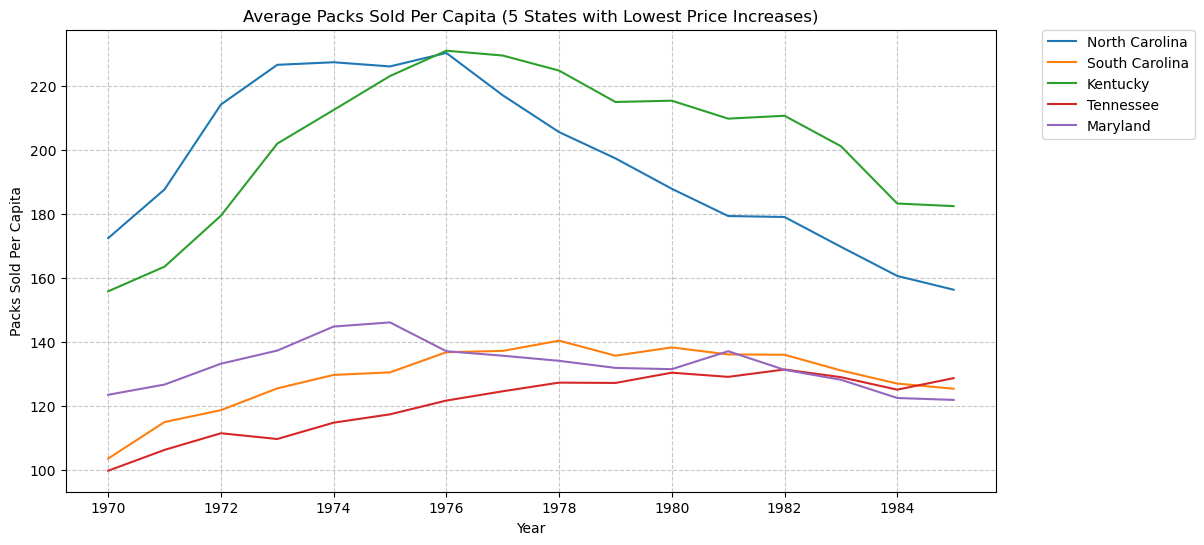

In [23]:
plt.figure(figsize=(12, 6))

for state in bottom5_states:
    state_data = packs_per_capita[packs_per_capita['state'] == state]
    plt.plot(state_data['Year'], state_data['sales_per_capita'], label=state)

plt.title('Average Packs Sold Per Capita (5 States with Lowest Price Increases)')
plt.xlabel('Year')
plt.ylabel('Packs Sold Per Capita')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

5. Compare the trends in sales from the 5 states with the highest price increases to those with the lowest price increases.

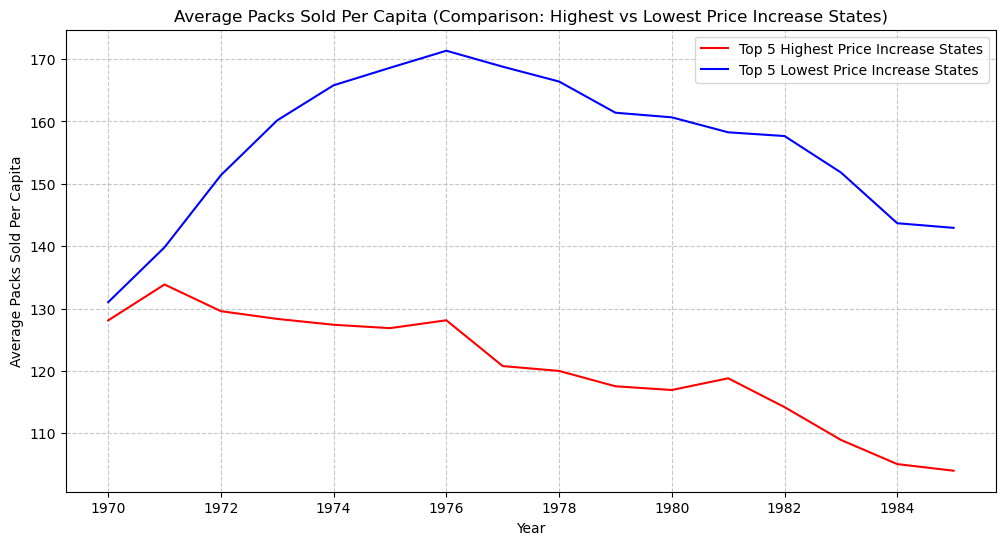

In [24]:
# Group by year and calculate mean sales_per_capita for each group (top 5 and bottom 5)

top5_avg = top5_df.groupby('Year')['sales_per_capita'].mean().reset_index()
bottom5_avg = bottom5_df.groupby('Year')['sales_per_capita'].mean().reset_index()

plt.figure(figsize=(12,6))
plt.plot(top5_avg['Year'], top5_avg['sales_per_capita'], label='Top 5 Highest Price Increase States', color='red')
plt.plot(bottom5_avg['Year'], bottom5_avg['sales_per_capita'], label='Top 5 Lowest Price Increase States', color='blue')

plt.title('Average Packs Sold Per Capita (Comparison: Highest vs Lowest Price Increase States)')
plt.xlabel('Year')
plt.ylabel('Average Packs Sold Per Capita')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

The five states with the largest increases in cigarette prices saw a sharp decline in packs sold per capita from 1970 to 2018, indicating the influence of higher prices and likely stricter tobacco control policies. In contrast, the five states with the smallest price increases experienced more stable cigarette consumption over time, with only a gradual decline. This suggests that states with smaller price hikes, many of which have historical ties to tobacco production, were less proactive in using price-based policies to discourage smoking.

6. Focusing only on the time period from 1970 to 1990, regress log sales on log prices to estimate the price elasticity of demand over that period. Interpret your results.

In [28]:
# Create separate copy for question
df_q6 = df.copy()
# Filter for 1970-1990
df_q6 = df_q6[(df_q6['Year'] >= 1970) & (df_q6['Year'] <= 1990)]

# Drop rows with missing values in price or sales
df_q6 = df_q6.dropna(subset=['cost_per_pack', 'sales_per_capita'])

# Take logs
df_q6['log_sales_per_capita'] = np.log(df_q6['sales_per_capita'])
df_q6['log_price_per_pack'] = np.log(df_q6['cost_per_pack'])

# Regression: log(sales_per_capita) ~ log(cost_per_pack)
X = sm.add_constant(df_q6['log_price_per_pack'])  
# Add intercept
y = df_q6['log_sales_per_capita']

model = sm.OLS(y, X).fit()

# Output results
print(model.summary())

# Get elasticity (the slope coefficient)
elasticity = model.params['log_price_per_pack']
print(f"Estimated Price Elasticity of Demand: {elasticity:.2f}")

                             OLS Regression Results                             
Dep. Variable:     log_sales_per_capita   R-squared:                       0.023
Model:                              OLS   Adj. R-squared:                  0.021
Method:                   Least Squares   F-statistic:                     18.82
Date:                  Wed, 05 Mar 2025   Prob (F-statistic):           1.62e-05
Time:                          20:13:53   Log-Likelihood:                 116.37
No. Observations:                   816   AIC:                            -228.7
Df Residuals:                       814   BIC:                            -219.3
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const           

The estimated price elasticity of demand for cigarettes from 1970 to 1990 is about -0.093, meaning that a 10% rise in cigarette prices corresponds to a 0.93% decline in per capita cigarette sales. This indicates that demand was relatively inelastic during this period, suggesting consumers were not highly sensitive to price changes.

7. Again limiting to 1970 to 1990, regress log sales on log prices using the total (federal and state) cigarette tax (in dollars) as an instrument for log prices. Interpret your results and compare your estimates to those without an instrument. Are they different? If so, why?

In [29]:
# Create separate copy for question
df_q7 = df.copy()
# Drop rows with missing data in price, sales, or tax
df_q7 = df_q7.dropna(subset=['cost_per_pack', 'sales_per_capita', 'tax_dollar'])

# Create log variables
df_q7['log_sales_per_capita'] = np.log(df_q7['sales_per_capita'])
df_q7['log_price_per_pack'] = np.log(df_q7['cost_per_pack'])

# Step 1: Define variables for 2SLS
y = df_q7['log_sales_per_capita']   # Dependent variable
X = df_q7[['log_price_per_pack']]   # Endogenous regressor (price)
Z = df_q7[['tax_dollar']]           # Instrument (tax in dollars)

# Add constant to X (explanatory variables) for the regression
X = sm.add_constant(X)

In [33]:
# Run 2SLS regression
model_iv = IV2SLS(dependent=y, exog=X[['const']], endog=X['log_price_per_pack'], instruments=Z).fit()

# Show results
print(model_iv.summary)

# Get IV estimate of elasticity
elasticity_iv = model_iv.params['log_price_per_pack']
print(f"\nInstrumented Price Elasticity of Demand: {elasticity_iv:.2f}")

                           IV-2SLS Estimation Summary                           
Dep. Variable:     log_sales_per_capita   R-squared:                     -0.0501
Estimator:                      IV-2SLS   Adj. R-squared:                -0.0514
No. Observations:                   816   F-statistic:                    79.982
Date:                  Wed, Mar 05 2025   P-value (F-stat)                0.0000
Time:                          20:23:35   Distribution:                  chi2(1)
Cov. Estimator:                  robust                                         
                                                                                
                                 Parameter Estimates                                  
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
const                  4.7090     0.0149     315.62     0.0000      4.6798      4.7383
log_

Using cigarette taxes as an instrument for prices, the estimated price elasticity of demand for cigarettes between 1970 and 1990 is about -0.26. This implies that a 10% rise in cigarette prices leads to a 2.6% decline in per capita cigarette sales, confirming that demand remains relatively inelastic. Compared to the OLS estimate of -0.093, this IV estimate suggests a greater sensitivity to price changes. The difference indicates that the OLS regression likely underestimated the true elasticity, potentially due to endogeneity bias—where factors like state-level anti-smoking campaigns or cultural attitudes toward smoking may simultaneously impact both cigarette consumption and pricing. By leveraging taxes as an instrument, the IV approach isolates the effect of external price shifts driven by policy, offering a more accurate measure of consumer responsiveness to price changes.

8. Show the first stage and reduced-form results from the instrument.

In [35]:
# Create separate copy for question
df_q8 = df.copy()
# Filter data for 1970 to 1990
df_q8 = df_q8[(df_q8['Year'] >= 1970) & (df_q8['Year'] <= 1990)]

df_q8 = df_q8.dropna(subset=['cost_per_pack', 'sales_per_capita', 'tax_dollar'])

# Take logs
df_q8['log_sales_per_capita'] = np.log(df_q8['sales_per_capita'])
df_q8['log_price_per_pack'] = np.log(df_q8['cost_per_pack'])

X_first_stage = sm.add_constant(df_q8['tax_dollar'])
y_first_stage = df_q8['log_price_per_pack']

first_stage_model = sm.OLS(y_first_stage, X_first_stage).fit()
print("First Stage Regression Results:")
print(first_stage_model.summary())

X_reduced_form = sm.add_constant(df['tax_dollar'])
y_reduced_form = df_q8['log_sales_per_capita']

reduced_form_model = sm.OLS(y_reduced_form, X_reduced_form).fit()
print("\nReduced Form Regression Results:")
print(reduced_form_model.summary())

First Stage Regression Results:
                            OLS Regression Results                            
Dep. Variable:     log_price_per_pack   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     1138.
Date:                Wed, 05 Mar 2025   Prob (F-statistic):          1.00e-156
Time:                        20:27:45   Log-Likelihood:                 71.316
No. Observations:                 816   AIC:                            -138.6
Df Residuals:                     814   BIC:                            -129.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.434

The first stage regression shows that cigarette taxes are strongly associated with a positive relationship with cigarette prices, with a statistically significant coefficient, confirming that taxes are a strong and relevant instrument for price.

9. Repeat questions 1-3 focusing on the period from 1991 to 2015.

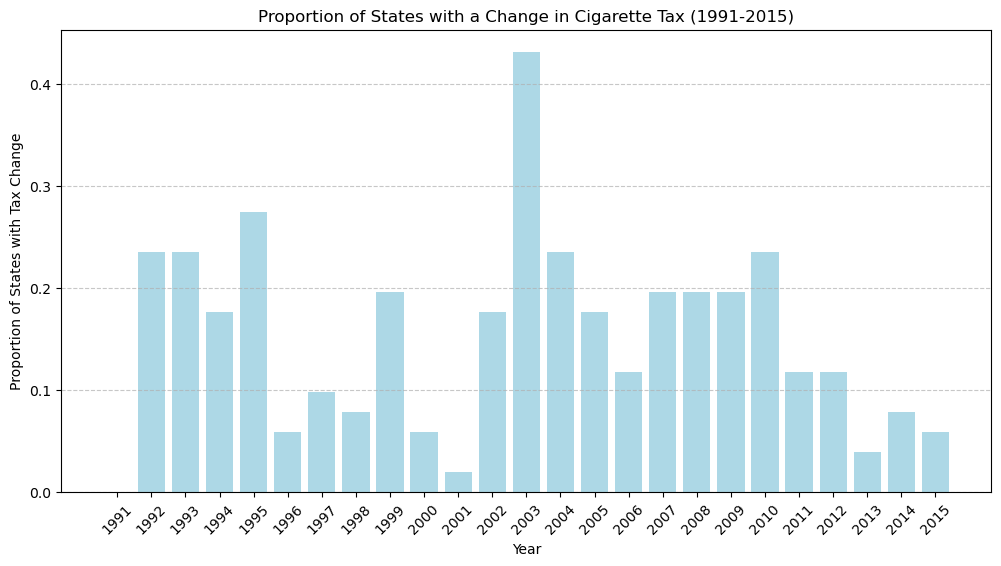

In [39]:
# Create separate copy for question 
df_q9 = pd.read_csv("/Users/sarinatan/Desktop/HLTH470hw3/data/output/TaxBurden_Data.csv")
df_q9['tax_change'] = df_q9.groupby('state')['tax_state'].diff().notna()
prop_change = df_q9.groupby('Year')['tax_change'].mean()
# Filter for the period 1991 to 2015
df_q9 = df_q9[(df_q9['Year'] >= 1991) & (df_q9['Year'] <= 2015)]

# Sort by state and year to allow comparison across years
df_q9 = df_q9.sort_values(by=['state', 'Year'])

# Create a column that identifies whether the tax changed compared to the previous year
df_q9['tax_change'] = df_q9.groupby('state')['tax_state'].diff().notnull() & (df_q9.groupby('state')['tax_state'].diff() != 0)

# Calculate the proportion of states with a tax change each year
# Total number of states each year
states_per_year = df_q9.groupby('Year')['state'].nunique()

# Number of states with a tax change each year
states_with_change_per_year = df_q9[df_q9['tax_change']].groupby('Year')['state'].nunique()

# Proportion of states with a tax change
proportion_with_change = (states_with_change_per_year / states_per_year).fillna(0).reset_index()
proportion_with_change.columns = ['Year', 'Proportion']

# Plot the bar graph
plt.figure(figsize=(12, 6))
plt.bar(proportion_with_change['Year'], proportion_with_change['Proportion'], color='lightblue')

plt.title('Proportion of States with a Change in Cigarette Tax (1991-2015)')
plt.xlabel('Year')
plt.ylabel('Proportion of States with Tax Change')
plt.xticks(proportion_with_change['Year'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

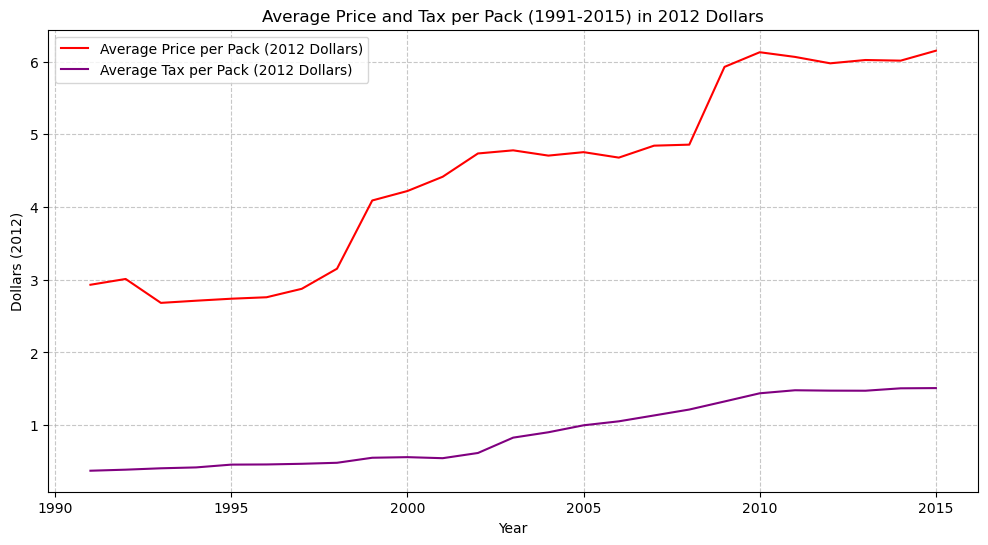

In [40]:
df_q9 = df_q9[(df_q9['Year'] >= 1991) & (df_q9['Year'] <= 2015)]

# Use CPI to adjust to 2012 dollars
# Assuming 2012 CPI = 230 (You should check the exact CPI value for 2012 from your dataset if available)
df_q9['cost_per_pack_2012'] = df_q9['cost_per_pack'] * (230 / df_q9['index'])
df_q9['tax_state_2012'] = df_q9['tax_state'] * (230 / df_q9['index'])

# Group by year and compute average across all states
annual_avg = df_q9.groupby('Year').agg({
    'cost_per_pack_2012': 'mean',
    'tax_state_2012': 'mean'
}).reset_index()

# Plot
plt.figure(figsize=(12, 6))

plt.plot(annual_avg['Year'], annual_avg['cost_per_pack_2012'], label='Average Price per Pack (2012 Dollars)', color='red')
plt.plot(annual_avg['Year'], annual_avg['tax_state_2012'], label='Average Tax per Pack (2012 Dollars)', color='purple')

plt.title('Average Price and Tax per Pack (1991-2015) in 2012 Dollars')
plt.xlabel('Year')
plt.ylabel('Dollars (2012)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

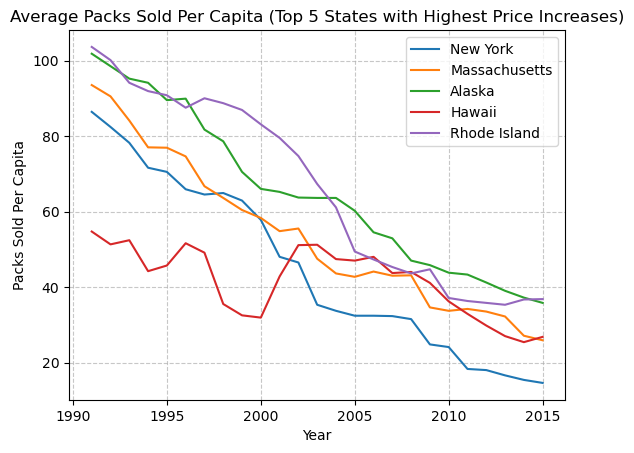

In [41]:
df_q9 = df_q9[(df_q9['Year'] >= 1991) & (df_q9['Year'] <= 2015)]

# Identify price change over time per state
price_change = df_q9.groupby('state')['cost_per_pack'].agg(['first', 'last']).reset_index()
price_change['price_increase'] = price_change['last'] - price_change['first']

# Get top 5 states with highest price increases
top5_states = price_change.sort_values('price_increase', ascending=False).head(5)['state']

# Filter dataset to only those states
top5_df = df_q9[df_q9['state'].isin(top5_states)]

# Group by year and state to calculate average packs sold per capita
packs_per_capita = top5_df.groupby(['Year', 'state'])['sales_per_capita'].mean().reset_index()

for state in top5_states:
    state_data = packs_per_capita[packs_per_capita['state'] == state]
    plt.plot(state_data['Year'], state_data['sales_per_capita'], label=state)

plt.title('Average Packs Sold Per Capita (Top 5 States with Highest Price Increases)')
plt.xlabel('Year')
plt.ylabel('Packs Sold Per Capita')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

10. Compare your elasticity estimates from 1970-1990 versus those from 1991-2015. Are they different? If so, why?

In [54]:
df_q10 = pd.read_csv("/Users/sarinatan/Desktop/HLTH470hw3/data/output/TaxBurden_Data.csv")

df_q10 = df_q10[(df_q10['Year'] >= 1991) & (df_q10['Year'] <= 2015)]

# Drop rows with missing values in price or sales
df_q10 = df_q10.dropna(subset=['cost_per_pack', 'sales_per_capita'])

# Take logs
df_q10['log_sales_per_capita'] = np.log(df_q10['sales_per_capita'])
df_q10['log_price_per_pack'] = np.log(df_q10['cost_per_pack'])

# Regression: log(sales_per_capita) ~ log(cost_per_pack)
X = sm.add_constant(df_q10['log_price_per_pack'])  

# Add intercept
y = df_q10['log_sales_per_capita']

model = sm.OLS(y, X).fit()

# Output results
print(model.summary())

# Get elasticity (the slope coefficient)
elasticity = model.params['log_price_per_pack']
print(f"Estimated Price Elasticity of Demand: {elasticity:.2f}")

                             OLS Regression Results                             
Dep. Variable:     log_sales_per_capita   R-squared:                       0.533
Model:                              OLS   Adj. R-squared:                  0.532
Method:                   Least Squares   F-statistic:                     1451.
Date:                  Wed, 05 Mar 2025   Prob (F-statistic):          1.52e-212
Time:                          20:53:53   Log-Likelihood:                -296.47
No. Observations:                  1275   AIC:                             596.9
Df Residuals:                      1273   BIC:                             607.2
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const           

Compared to my elasticity estimated for 1970-1990, my estimated price elasticity of demand was -0.67 for 1991-2015. This implies that a 10% rise in cigarette prices leads to a 6.7% decline in per capita cigarette sales, confirming that demand still remains inelastic, but less than 1970-1990. This suggests consumers are more price-sensitive, though demand is still inelastic (absolute value is less than 1). This could mean that while price matters more in purchasing decisions, other factors (like addiction or brand loyalty) still play a role.